
# CM3015 Machine Learning and Neural Networks
# End of term coursework

[Introduction](#intro) <br>
[Methodology](#method) <br>
-[Create a input pipeline](#input) <br>
-[Train a model](#model) <br>
[Results](#result) <br>
[Conclusion](#conclusion)<br>
[Refrences](#ref)

<a id = "intro"><a>

## Introduction 

This project follows the universal workflow of machine learning from DLWP 4.5 (p.111). <br>
Based on this workflow, the project first needs to define the problem and assembling the dataset. The problem that this project trying to solve is the multiclass image classification of fashion items. More specifically, it is single label, multiclass classfication since each data should be classfied into one category, fashion item.
This project will develop the ML model that will classify the type of fashion item. The inputs to the model will be the image of a fashion item and the output will be the type or label of a fashion item such as trousers or dress.
This project will be using the dataset "fashion_mnist"(https://www.tensorflow.org/datasets/catalog/fashion_mnist) from TensorFlow Dataset.  When building an ML model, there are few problems that I need to be aware of. One example is nonstationary problems can occur when a model is trying to predict something dependent on the season. For example, making fashion recommendations for winter based on the data from August will not work. However, the problem for this project is stationary and nonstationary problems will not apply. 

The measure of success for this problem will be accuracy. How accurate the model can classify the fashion item will be the most important. The model will choose the loss function based on this measure. 

### Data preparation 

As I mentioned, I will be using "fashion_mnist" dataset (https://www.tensorflow.org/datasets/catalog/fashion_mnist) from TensorFlow Dataset.<br>
The dataset is designed the same way as MNIST dataset. It consists of 60,000 grayscale images of 28x28 pixels and additional 10,000images for the test. Therefore, I can hypothesize that my output can be predicted from the input which is the image of a fashion item and the dataset is informative enough for the model to learn relationships between inputs image and output label.<br>
To use the dataset from the TensorFlow dataset, I need to install the following package. 

In [1]:
!pip install tensorflow-datasets -q

This is the stable version of the TensorFlow dataset package. There is another version that updates datasets daily but that is not required for this project and a stable version is more suitable. 

Install all necessary packages for this project

In [2]:
!pip install tensorflow -q

Package to automate hyperparameter optimization

In [3]:
!pip install keras-tuner --upgrade -q

Import all necessaru modlues for this projecrt

In [250]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras_tuner as kt

import tensorflow_datasets as tfds 


import IPython

Now, the dataset can be load to this project with the following code. 
```python 
ds = tfds.load('fashion_mnist', split, shuffle_files)
```
The split argument will determine how to split the dataset, and the shuffle_files argument specifies whether shullfle the dataset or not. These will be specifies as train the model.

<a id="method"></a>

## Methodology 

[Introduction](#intro) <br>
[Methodology](#method) <br>
-[Create a input pipeline](#input) <br>
-[Train a model](#model) <br>
[Results](#result) <br>
[Conclusion](#conclusion)<br>
[Refrences](#ref)

First, the data needs to be ready to fed into the model.

<a id="input"/>

### Create a input pipeline

Load TensorFlow dataset for taining a neural network with Keras. <br>
Dataset is split into three sets, train, test, and validartion. Train and test sets are used for train a model and some data is set aside for validation. 

In [5]:
(ds_train, ds_test, ds_val), ds_info = tfds.load(
    'fashion_mnist',
    split=['train[2000:]', 'test', 'train[:2000]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)

The following is the detail information about this dataset

In [6]:
print('ds_train', len(ds_train))
print('ds_test', len(ds_test))
print('ds_val', len(ds_val))

ds_train 58000
ds_test 10000
ds_val 2000


Creating a train pipeline

In [7]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)   

Creating a evaluation pipeline

In [8]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
ds_val = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_test.batch(128)
ds_val = ds_test.cache()
ds_val = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

refrence :<br> TensorFlow dataset https://www.tensorflow.org/datasets/keras_example 

Before start trin a model, here are two functions to plot a graph of loss and accuracy between train dataset and test dataset 

In [10]:
def plot_loss(loss, val_loss):
    '''plot training loss and validation loss on the graph'''
    plt.clf() #clear any existing figures
    epochs = range(1, len(loss)+1) #get a number of epochs
    #assign values for each axis
    plt.plot(epochs, loss, 'bo', label="Training loss")
    plt.plot(epochs, val_loss, 'b', label="validation loss")
    #set a title of graph and labels of each axis
    plt.title("Training and Validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(acc, val_acc):
    '''plot training accuracy and validation accuracy'''
    plt.clf() #clear any existing figures
    epochs = range(1, len(acc)+1) #get a number of epochs
    #assign values for each axis
    plt.plot(epochs, acc, 'bo', label="Training accuracy")
    plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
    #set a title of graph and labels of each axis
    plt.title("Training and validation accuracy")
    plt.xlabel('Epochs')
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

These graps help understand the performance of each model.

<a id="model" />

### Train a model

[Base line](#base)<br>
[Overfit](#over)<br>
[Model development](#mod)<br>
[Automated hyperparameter optimization](#auto)

To create a model, I will use Keras. Since it is already included in the TensorFlow module, there is no need for importing other modules. <br>
To develop a model, there are a few things that I need to specify beforehand. Based on table 4.1 from DLWP 4.5.5, I will use "softmax" for last layer activation, and "categorical_crossentropy" for a  loss function. Since I am dealing with a multiclass, single-label classification problem, those are the most effective ones. For optimization, I will use "rmsprop" and "tensorflow.keras.optimizers.Adam". The first one is recommended on DLWP and the second one has been used on an example from the TensorFlow library (https://www.tensorflow.org/datasets/keras_example). 


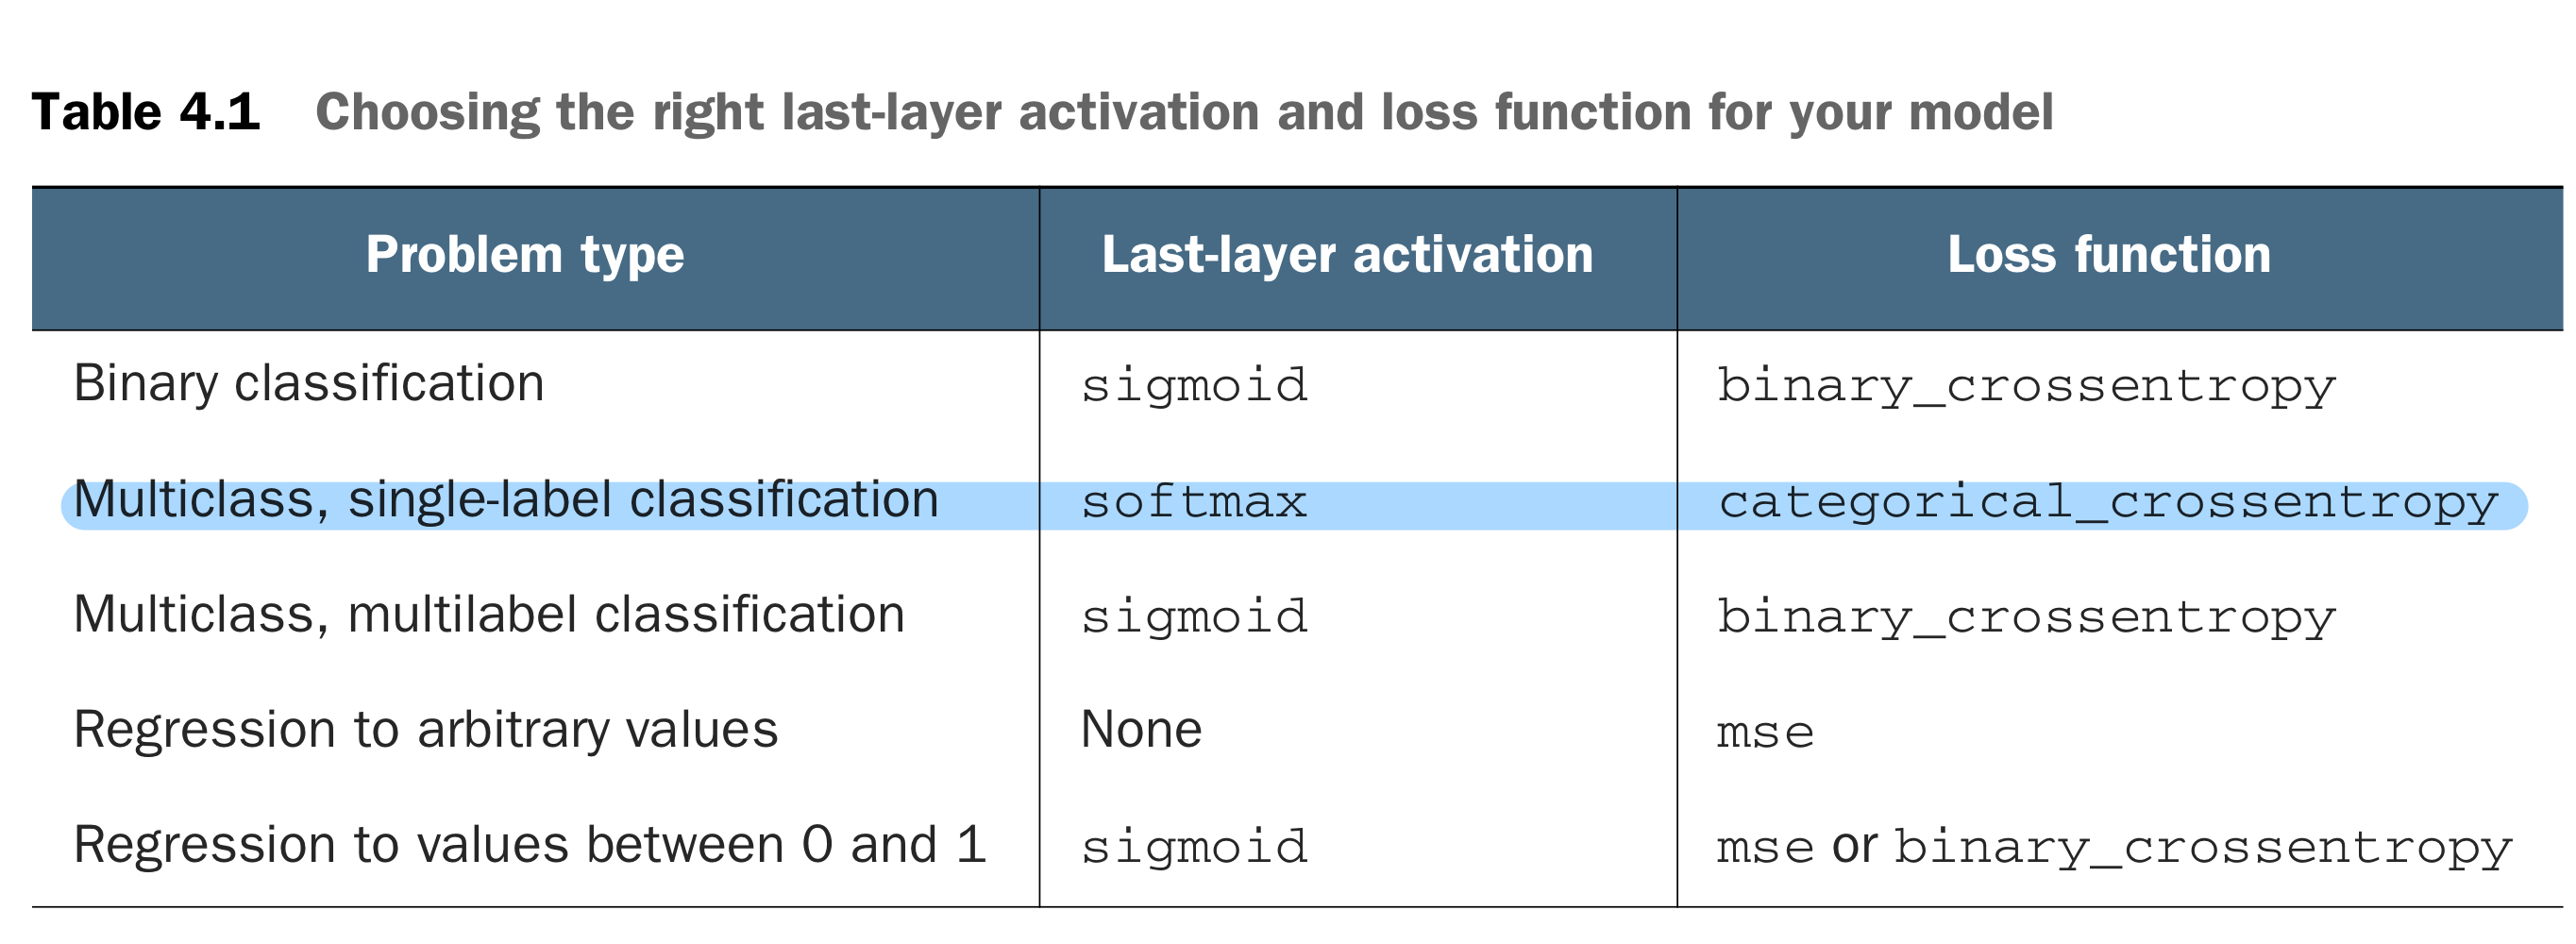

<span style="color:red">Because each datasets are shuffled before feed into a model, when you train a model result may differe from ones that are shown here.</span>

<a id="base" />

##### Baseline model

In the first step, I will develop a model that performs better than a baseline. For example, the MIST digit classification model with greater than 10% accuracy is considered that it has archive statistical power. So, this first model will aim to have better accuracy than 10%.

Throughout this coursework, I will be following the basic build and train process from the DLWP. 

Build layers

In [12]:
# buid
model_base = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(16, activation='softmax')
])

In [13]:
model_base.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train a model

In [14]:
#Train
history_base = model_base.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test,
)

Epoch 1/5


/Users/kyonkyon/Library/Python/3.7/lib/python/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


454/454 [==============================] - 4s 3ms/step - loss: 1.9410 - accuracy: 0.3433 - val_loss: 1.2905 - val_accuracy: 0.5470
Epoch 2/5
454/454 [==============================] - 1s 1ms/step - loss: 1.0563 - accuracy: 0.5930 - val_loss: 0.9167 - val_accuracy: 0.6676
Epoch 3/5
454/454 [==============================] - 1s 2ms/step - loss: 0.8227 - accuracy: 0.7012 - val_loss: 0.7908 - val_accuracy: 0.7126
Epoch 4/5
454/454 [==============================] - 1s 1ms/step - loss: 0.7472 - accuracy: 0.7272 - val_loss: 0.7300 - val_accuracy: 0.7299
Epoch 5/5
454/454 [==============================] - 1s 1ms/step - loss: 0.6603 - accuracy: 0.7637 - val_loss: 0.6403 - val_accuracy: 0.7772


refrence :<br> TensorFLow dataset https://www.tensorflow.org/datasets/keras_example <br>
DLWP 3.5 "Classifying newswires: a multiclass classification example"


Plotting a result of this model

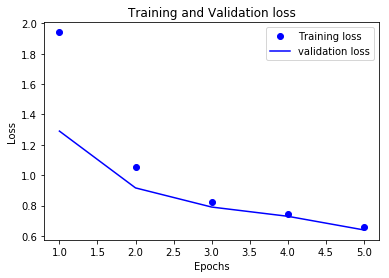

In [15]:
plot_loss(history_base.history['loss'], history_base.history['val_loss'])

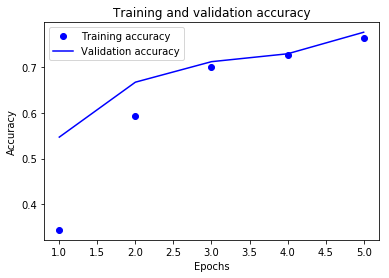

In [16]:
plot_accuracy(history_base.history['accuracy'], history_base.history['val_accuracy'])

In [17]:
model_base.evaluate(ds_val)

79/79 [==============================] - 0s 998us/step - loss: 0.6403 - accuracy: 0.7772


[0.6402767300605774, 0.7771999835968018]

This model has higher accuracy than 10% thus I can state that this model achieved statistical power which means it is better than baseline. Because it achieved statistical power, two hypothesises that I made earlier are true. My outputs can be predicted based on the input and the dataset is informative enough to learn relationships between input and output. Therefore, I can continue to train a model for this dataset.

<a id="over" />

##### Overfits

In the next step, I will develop a model that overfits. <br> 
To archive this, I will add layers, make layers bigger and increase the number of epochs.

In [18]:
model_overfit = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(124,activation='relu'),
  tf.keras.layers.Dense(124,activation='relu'),
  tf.keras.layers.Dense(124,activation='relu'),
  tf.keras.layers.Dense(64,activation='relu'),
  tf.keras.layers.Dense(46, activation='softmax')
])
model_overfit.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
history_overfit = model_overfit.fit(
    ds_train,
    epochs=12,
    validation_data=ds_test,
)

Epoch 1/12
454/454 [==============================] - 2s 3ms/step - loss: 0.6119 - accuracy: 0.7880 - val_loss: 0.5005 - val_accuracy: 0.8205
Epoch 2/12
454/454 [==============================] - 1s 3ms/step - loss: 0.3993 - accuracy: 0.8566 - val_loss: 0.3968 - val_accuracy: 0.8588
Epoch 3/12
454/454 [==============================] - 1s 3ms/step - loss: 0.3531 - accuracy: 0.8707 - val_loss: 0.3835 - val_accuracy: 0.8633
Epoch 4/12
454/454 [==============================] - 1s 3ms/step - loss: 0.3282 - accuracy: 0.8783 - val_loss: 0.3644 - val_accuracy: 0.8686
Epoch 5/12
454/454 [==============================] - 1s 3ms/step - loss: 0.3051 - accuracy: 0.8874 - val_loss: 0.3484 - val_accuracy: 0.8740
Epoch 6/12
454/454 [==============================] - 1s 3ms/step - loss: 0.2923 - accuracy: 0.8915 - val_loss: 0.3652 - val_accuracy: 0.8722
Epoch 7/12
454/454 [==============================] - 1s 3ms/step - loss: 0.2775 - accuracy: 0.8971 - val_loss: 0.3382 - val_accuracy: 0.8755
Epoch 

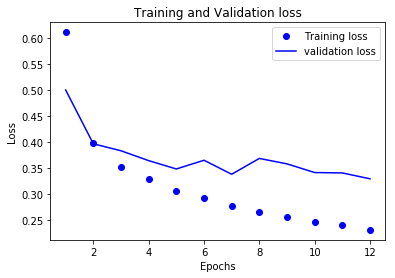

In [19]:
plot_loss(history_overfit.history['loss'], history_overfit.history['val_loss'])

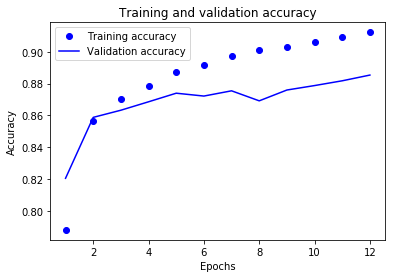

In [20]:
plot_accuracy(history_overfit.history['accuracy'], history_overfit.history['val_accuracy'])

As the result shows, this model overfits. When validation accuracy decreases, it means a model overfits. With this model evaluation accuracy decrease around epochs 6. 

<a id="mod" />

##### Developing a well perform model

Now, there are a model that does better than baseline and another model that overfits.<br>
Finally, I will try to archive its best performance. This can be done in many different ways such as modifying the architecture of a model, add dropout, add L1 or L2 regularization, and look for an optimal configuration. <br>
The main purpose of this process is to achieve the highest accuracy without overfitting a model.

Since prvious model overfits around 6 epochs, I will first traina model with 5 epochs. 

First, I reduced a number of layers and size of each layers.

In [21]:
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(46,activation='relu'),
  tf.keras.layers.Dense(46,activation='relu'),
  tf.keras.layers.Dense(16, activation='softmax')
])
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
history_1 = model_1.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test,
)

Epoch 1/5
454/454 [==============================] - 1s 2ms/step - loss: 0.6597 - accuracy: 0.7807 - val_loss: 0.4964 - val_accuracy: 0.8246
Epoch 2/5
454/454 [==============================] - 1s 2ms/step - loss: 0.4311 - accuracy: 0.8491 - val_loss: 0.4355 - val_accuracy: 0.8476
Epoch 3/5
454/454 [==============================] - 1s 2ms/step - loss: 0.3839 - accuracy: 0.8634 - val_loss: 0.4071 - val_accuracy: 0.8570
Epoch 4/5
454/454 [==============================] - 1s 2ms/step - loss: 0.3618 - accuracy: 0.8691 - val_loss: 0.4287 - val_accuracy: 0.8462
Epoch 5/5
454/454 [==============================] - 1s 2ms/step - loss: 0.3442 - accuracy: 0.8751 - val_loss: 0.3772 - val_accuracy: 0.8664


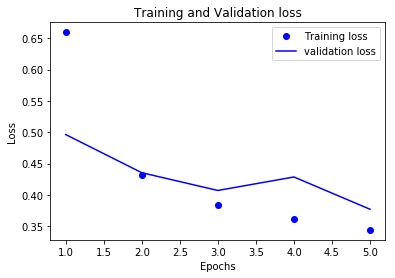

In [22]:
plot_loss(history_1.history['loss'], history_1.history['val_loss'])

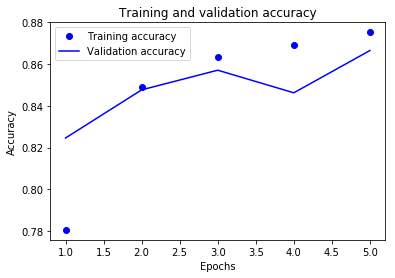

In [23]:
plot_accuracy(history_1.history['accuracy'], history_1.history['val_accuracy'])

As result shows, it still overfits. So, I need modify a model. 

On the next approach, I added a dropout layer and modify some layers.<br>
Dropout is one of the most effective ways of regularization. Also, I change the optimizer to "rmsprop".

In [24]:
model_2 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(46, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(16, activation='softmax')
])
model_2.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
history_2 = model_2.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test,
)

Epoch 1/5
454/454 [==============================] - 1s 2ms/step - loss: 0.9000 - accuracy: 0.6919 - val_loss: 0.5276 - val_accuracy: 0.8177
Epoch 2/5
454/454 [==============================] - 1s 2ms/step - loss: 0.6023 - accuracy: 0.7925 - val_loss: 0.4713 - val_accuracy: 0.8346
Epoch 3/5
454/454 [==============================] - 1s 2ms/step - loss: 0.5535 - accuracy: 0.8062 - val_loss: 0.4721 - val_accuracy: 0.8259
Epoch 4/5
454/454 [==============================] - 1s 2ms/step - loss: 0.5285 - accuracy: 0.8137 - val_loss: 0.4520 - val_accuracy: 0.8389
Epoch 5/5
454/454 [==============================] - 1s 2ms/step - loss: 0.5140 - accuracy: 0.8177 - val_loss: 0.4337 - val_accuracy: 0.8414


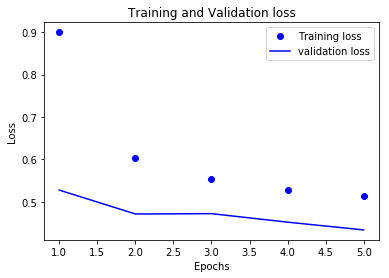

In [25]:
plot_loss(history_2.history['loss'], history_2.history['val_loss'])

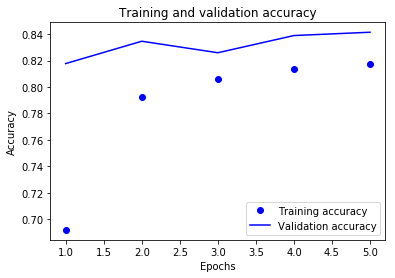

In [26]:
plot_accuracy(history_2.history['accuracy'], history_2.history['val_accuracy'])

Evaluate a model with validation data that I kept aside from training and testing dataset

It is better than previous models. But there are still some room to try different things

For this model, I modify the layers and add another regularization addition to Dropzero, which is L1 regularizer as an activity regularizer. Also, I increase the number of epochs to 10 to see how the model does with more epochs. Also, I modify an optimizer.

In [27]:
model_3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(16 , activity_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  tf.keras.layers.Dense(16 , activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(16, activation='softmax')
])
model_3.compile(
    optimizer=tf.keras.optimizers.Adam(0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
history_3 = model_3.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
)

Epoch 1/10
454/454 [==============================] - 1s 2ms/step - loss: 1.9266 - accuracy: 0.3759 - val_loss: 1.0694 - val_accuracy: 0.7197
Epoch 2/10
454/454 [==============================] - 1s 2ms/step - loss: 1.0982 - accuracy: 0.6528 - val_loss: 0.7696 - val_accuracy: 0.7929
Epoch 3/10
454/454 [==============================] - 1s 2ms/step - loss: 0.8809 - accuracy: 0.7361 - val_loss: 0.6689 - val_accuracy: 0.8093
Epoch 4/10
454/454 [==============================] - 1s 2ms/step - loss: 0.7864 - accuracy: 0.7626 - val_loss: 0.6130 - val_accuracy: 0.8227
Epoch 5/10
454/454 [==============================] - 1s 2ms/step - loss: 0.7336 - accuracy: 0.7812 - val_loss: 0.5801 - val_accuracy: 0.8300
Epoch 6/10
454/454 [==============================] - 1s 2ms/step - loss: 0.6977 - accuracy: 0.7897 - val_loss: 0.5589 - val_accuracy: 0.8342
Epoch 7/10
454/454 [==============================] - 1s 2ms/step - loss: 0.6678 - accuracy: 0.7987 - val_loss: 0.5470 - val_accuracy: 0.8367
Epoch 

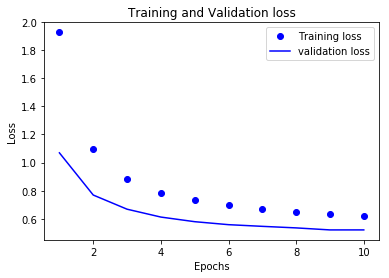

In [28]:
plot_loss(history_3.history['loss'], history_3.history['val_loss'])

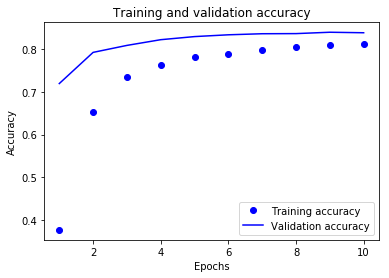

In [29]:
plot_accuracy(history_3.history['accuracy'], history_3.history['val_accuracy'])

In [30]:
model_3.evaluate(ds_val)

79/79 [==============================] - 0s 937us/step - loss: 0.5217 - accuracy: 0.8390


[0.5217254161834717, 0.8389999866485596]

It actually perform well, but quite similar to previous one.

In [31]:
model_4 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(16 , activity_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  tf.keras.layers.Dense(16 , activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(16, activation='softmax')
])
model_4.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
history_4 = model_4.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test,
)

Epoch 1/5
454/454 [==============================] - 1s 2ms/step - loss: 1.3892 - accuracy: 0.5547 - val_loss: 0.7072 - val_accuracy: 0.7939
Epoch 2/5
454/454 [==============================] - 1s 2ms/step - loss: 0.7651 - accuracy: 0.7676 - val_loss: 0.5812 - val_accuracy: 0.8266
Epoch 3/5
454/454 [==============================] - 1s 2ms/step - loss: 0.6674 - accuracy: 0.7976 - val_loss: 0.5425 - val_accuracy: 0.8368
Epoch 4/5
454/454 [==============================] - 1s 2ms/step - loss: 0.6189 - accuracy: 0.8117 - val_loss: 0.5127 - val_accuracy: 0.8427
Epoch 5/5
454/454 [==============================] - 1s 2ms/step - loss: 0.5914 - accuracy: 0.8203 - val_loss: 0.5009 - val_accuracy: 0.8467


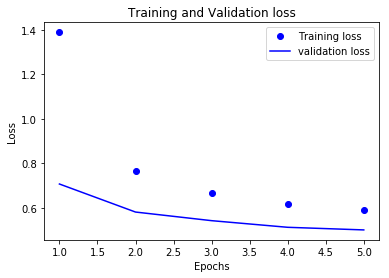

In [32]:
plot_loss(history_4.history['loss'], history_4.history['val_loss'])

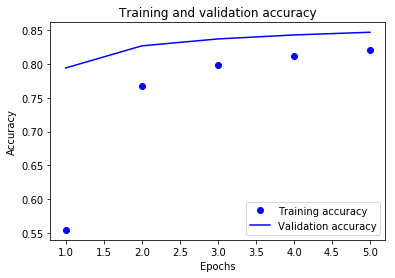

In [33]:
plot_accuracy(history_4.history['accuracy'], history_4.history['val_accuracy'])

In [34]:
model_4.evaluate(ds_val)

79/79 [==============================] - 0s 952us/step - loss: 0.5009 - accuracy: 0.8467


[0.5009394288063049, 0.8467000126838684]

For a last model, I changed regularizers to L1 and L2, and modify some layers.

In [35]:
model_5 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(46 , activity_regularizer=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001), activation='relu'),
  tf.keras.layers.Dense(16 , activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(46, activation='softmax')
])
model_5.compile(
    # optimizer=tf.keras.optimizers.Adam(0.001),
    optimizer='rmsprop',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
history_5 = model_5.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test,
)

Epoch 1/5
454/454 [==============================] - 1s 2ms/step - loss: 1.0556 - accuracy: 0.7032 - val_loss: 0.6138 - val_accuracy: 0.7989
Epoch 2/5
454/454 [==============================] - 1s 2ms/step - loss: 0.5814 - accuracy: 0.8169 - val_loss: 0.5030 - val_accuracy: 0.8338
Epoch 3/5
454/454 [==============================] - 1s 2ms/step - loss: 0.5020 - accuracy: 0.8406 - val_loss: 0.4774 - val_accuracy: 0.8440
Epoch 4/5
454/454 [==============================] - 1s 2ms/step - loss: 0.4665 - accuracy: 0.8500 - val_loss: 0.4599 - val_accuracy: 0.8475
Epoch 5/5
454/454 [==============================] - 1s 2ms/step - loss: 0.4421 - accuracy: 0.8567 - val_loss: 0.4528 - val_accuracy: 0.8449


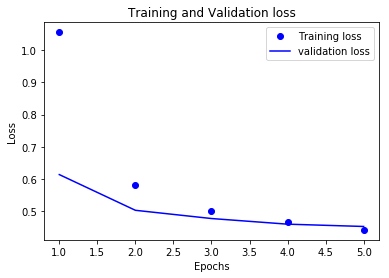

In [36]:
plot_loss(history_5.history['loss'], history_5.history['val_loss'])

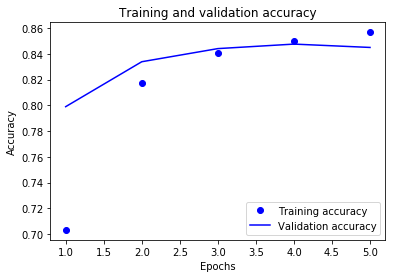

In [37]:
plot_accuracy(history_5.history['accuracy'], history_5.history['val_accuracy'])

This model overfits, thus modification was too much.

<a id="auto"></a>

##### Automated hyperparamter optimization

So far, I have been trying different parameters one by one based on the baseline model and overfit model. But this approach is not sufficient.
This process could be automated by using the KerasTuner package that I have installed.

With model_builder function, I define the image classification model. I set hyperparameter options based on the overfitted model, and one of the best performing models from the previous section.

In [275]:
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 16- 64
    hp_units = hp.Int('units', min_value = 16, max_value = 64, step = 12)
    model.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(hp.Choice("dropout", values=[0.1, 0.3, 0.5, 0.7, 0.9])))
    model.add(tf.keras.layers.Dense(units=10, activation="softmax"))

    model.compile(optimizer = 'rmsprop',
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])

    return model

Instantiate the tuner. The log of hyperparameter optimization will be saved in a new directory called log. <br>
Please note that every time executing this code, you need to delete the log directly otherwise it gives you an error.

In [276]:
tuner = kt.RandomSearch(model_builder,
                     objective = 'val_accuracy',
                     max_trials = 30,
                     directory = 'log',
                     project_name = 'end-of-term')

Define the call back function that clear out the output of the previous step.

In [277]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

The next function will do a random search for the best set of hyperparameters until there is no more available set of hyperparameters or trials number reaches 30. 

In [278]:
tuner.search(ds_train, epochs = 6, validation_data = ds_test, callbacks = [ClearTrainingOutput()])

Trial 18 Complete [00h 00m 06s]
val_accuracy: 0.8238999843597412

Best val_accuracy So Far: 0.8597999811172485
Total elapsed time: 00h 01m 52s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Oracle triggered exit because there are a no more unique set of parameters to run the trial.

In [279]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 30)[0]

Generate the new model with the result of the automated hyperparameter optimization.

In [300]:
model_best = tuner.hypermodel.build(best_hps)
history_best = model_best.fit(ds_train, epochs = 6, validation_data = ds_val)

Epoch 1/6
454/454 [==============================] - 1s 2ms/step - loss: 0.6596 - accuracy: 0.7732 - val_loss: 0.5612 - val_accuracy: 0.7931
Epoch 2/6
454/454 [==============================] - 1s 2ms/step - loss: 0.4590 - accuracy: 0.8391 - val_loss: 0.4626 - val_accuracy: 0.8363
Epoch 3/6
454/454 [==============================] - 1s 2ms/step - loss: 0.4088 - accuracy: 0.8558 - val_loss: 0.4242 - val_accuracy: 0.8497
Epoch 4/6
454/454 [==============================] - 1s 2ms/step - loss: 0.3826 - accuracy: 0.8633 - val_loss: 0.3954 - val_accuracy: 0.8555
Epoch 5/6
454/454 [==============================] - 1s 2ms/step - loss: 0.3621 - accuracy: 0.8695 - val_loss: 0.3902 - val_accuracy: 0.8604
Epoch 6/6
454/454 [==============================] - 1s 2ms/step - loss: 0.3484 - accuracy: 0.8742 - val_loss: 0.3977 - val_accuracy: 0.8607


Plot the result.

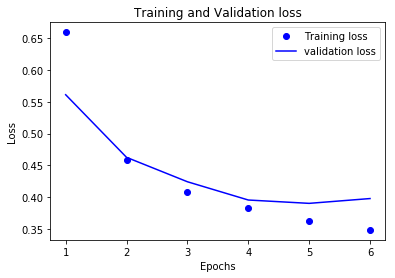

In [301]:
plot_loss(history_best.history['loss'], history_best.history['val_loss'])

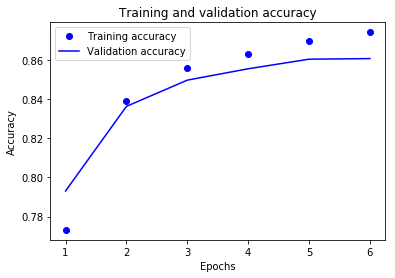

In [302]:
plot_accuracy(history_best.history['accuracy'], history_best.history['val_accuracy'])

<a id="result"></a>

## Result

[Introduction](#intro) <br>
[Methodology](#method) <br>
-[Create a input pipeline](#input) <br>
-[Train a model](#model) <br>
[Results](#result) <br>
[Conclusion](#conclusion)<br>
[Refrences](#ref)

As a result, I was able to archive about 84 to 85% accuracy. Here is a comparison between a model that archived statistical power, a model that overfits and a model that perform with good results. 

A model that archieved statistical power.

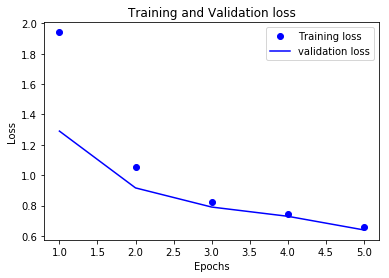

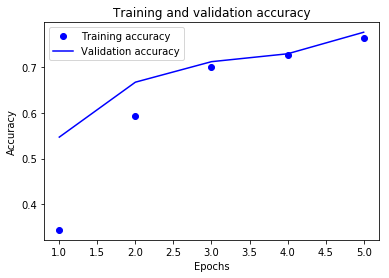

In [43]:
plot_loss(history_base.history['loss'], history_base.history['val_loss'])
plot_accuracy(history_base.history['accuracy'], history_base.history['val_accuracy'])

Overfits

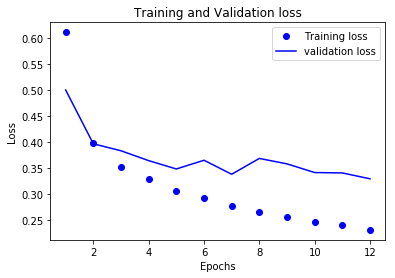

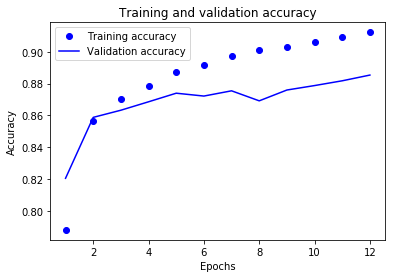

In [44]:
plot_loss(history_overfit.history['loss'], history_overfit.history['val_loss'])
plot_accuracy(history_overfit.history['accuracy'], history_overfit.history['val_accuracy'])

The best perform model that I was able to train.

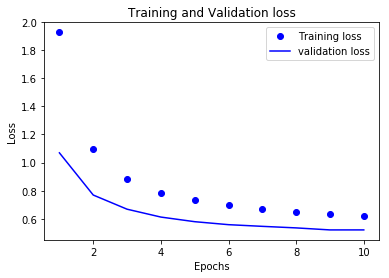

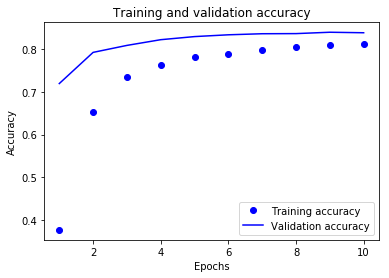

79/79 [==============================] - 0s 1ms/step - loss: 0.5217 - accuracy: 0.8390
Evaluation result of this model :  [0.5217254161834717, 0.8389999866485596]


In [45]:
plot_loss(history_3.history['loss'], history_3.history['val_loss'])
plot_accuracy(history_3.history['accuracy'], history_3.history['val_accuracy'])
result=model_3.evaluate(ds_val)
print("Evaluation result of this model : ", result)

With 3rd model that I train, I archieved 85% accuracy.

With the automated hyperparameter optimization, the model reached 86% accuracy with a validation data. <br>

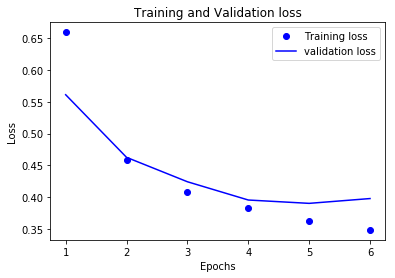

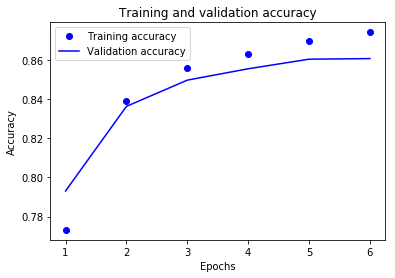

In [305]:
plot_loss(history_best.history['loss'], history_best.history['val_loss'])
plot_accuracy(history_best.history['accuracy'], history_best.history['val_accuracy'])

<a id="conclusion"></a>

## Conclusion 

[Introduction](#intro) <br>
[Methodology](#method) <br>
-[Create a input pipeline](#input) <br>
-[Train a model](#model) <br>
[Results](#result) <br>
[Conclusion](#conclusion)<br>
[Refrences](#ref)

Overall, I archived to train a model with reasonable accuracy. Since I chose a dataset from TensorFlow datasets collection, there was no trouble preparing data to feed into a model. In process of tuning a model sufficiently, it requires a lot of machine resources such as GPU. It is not sufficient to do every trial on my computer, and I had to try several different models. So, I decided to use Google collab to do the tuning process. It was quite hard to reach the accuracy of 80% or higher without overfits a model. The model became overfits quite easily so small modification of layers were necessary and was quite time-consuming.<br>
To achieve higher accuracy, I found that regularizers quite effective than reducing the size of each layer. A small number of a layer was necessary to achieve higher accuracy. I mainly used Dropout and L1/L2 regularizers but there should be many other effective ways that I did not explore in this coursework. <br>
Automated hyperparameter optimization is one way that I used to train the model. It could only archive similar accuracy to the best model that I could train by myself. However, it was a more efficient and easier way to do hyperparameter optimization. <br> 
There is some further development idea that I would like to try. After train the model, it should be able to predict with an image that is not in the database. It requires a pipeline to convert images to predictable format of image, then predicts that image. <br>
I think that with greater knowledge of ML and TensorFlow library, higher accuracy could be archived more efficiently. However, there were lots of things that I learned throughout this coursework.

<a id="ref" />

### Refrences for this coursework : 
TensorFlow dataset https://www.tensorflow.org/datasets/keras_example <br>
DLWP 3.5 "Classifying newswires: a multiclass classification example" <br>
O'REILLY https://www.oreilly.com/library/view/ai-and-machine/9781492078180/ch04.html <br>
TensorFlow https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer <br>
KerasTuner https://keras.io/guides/keras_tuner/getting_started/ <br>
KearsTuner https://keras.io/guides/keras_tuner/getting_started/

To train my model, I used Google collab https://colab.research.google.com

Refrence for the dataset that I used for this coursework : <br>
https://www.tensorflow.org/datasets/catalog/fashion_mnist

```JavaScript
@article{DBLP:journals/corr/abs-1708-07747,
  author    = {Han Xiao and
               Kashif Rasul and
               Roland Vollgraf},
  title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
               Algoritmhms},
  journal   = {CoRR},
  volume    = {abs/1708.07747},
  year      = {2017},
  url       = {http://arxiv.org/abs/1708.07747},
  archivePrefix = {arXiv},
  eprint    = {1708.07747},
  timestamp = {Mon, 13 Aug 2018 16:47:27 +0200},
  biburl    = {https://dblp.org/rec/bib/journals/corr/abs-1708-07747},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}
```

Refrence for automated hyperparameter optimization

```JavaScript
@misc{omalley2019kerastuner,
    title        = {Keras Tuner},
    author       = {O'Malley, Tom and Bursztein, Elie and Long, James and Chollet, Fran\c{c}ois and Jin, Haifeng and Invernizzi, Luca and others},
    year         = 2019,
    howpublished = {\url{https://github.com/keras-team/keras-tuner}}
}
```

Here is a history of my git repository for this coursework

In [46]:
!git log --pretty=format:"%h %s" --graph --abbrev-commit 

* 0dccdca final version
* f877263 add conclusion
* 3f968d6 methodology and result
* a3328fc second commit
* d3ec130 introduction
* b35fc0e first commit